In [ ]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')
import seaborn as sns
import os
import pandas as pd
from copy import deepcopy
from matplotlib import pyplot as plt
from os.path import join
import numpy as np
import imodelsx.process_results
import qa_questions
import random
import feature_spaces
import encoding_utils
import joblib
from tqdm import tqdm
import feature_spaces
fit_encoding = __import__('01_fit_encoding')

In [95]:
class A:
    use_test_setup = False
    subject = 'UTS03'
    feature_space = 'qa_embedder-10'
    qa_embedding_model = 'mistralai/Mistral-7B-v0.1'
    trim = 5


args = A()

In [96]:
story_names_train, story_names_test = fit_encoding.get_story_names(args)

In [97]:
features_downsampled_list = []
for qa_questions_version in ['v1', 'v2']:
    # Features
    features_downsampled_dict = feature_spaces.get_features(
        args.feature_space,
        allstories=story_names_train,
        qa_embedding_model=args.qa_embedding_model,
        qa_questions_version=qa_questions_version,
    )
    # n_time_points x n_features
    features_downsampled = encoding_utils.trim_and_normalize_features(
        features_downsampled_dict, args.trim, normalize=True
    )
    features_downsampled_list.append(deepcopy(features_downsampled))
features_downsampled_list = np.hstack(features_downsampled_list)

extracting qa_embedder embs...
Loading cached 0/82: gangstersandcookies
Loading cached 1/82: kiksuya
Loading cached 2/82: mybackseatviewofagreatromance
Loading cached 3/82: naked
Loading cached 4/82: vixenandtheussr
Loading cached 5/82: lifereimagined
Loading cached 6/82: thatthingonmyarm
Loading cached 7/82: mayorofthefreaks
Loading cached 8/82: birthofanation
Loading cached 9/82: life
Loading cached 10/82: theclosetthatateeverything
Loading cached 11/82: treasureisland
Loading cached 12/82: odetostepfather
Loading cached 13/82: notontheusualtour
Loading cached 14/82: thumbsup
Loading cached 15/82: againstthewind
Loading cached 16/82: gpsformylostidentity
Loading cached 17/82: goldiethegoldfish
Loading cached 18/82: goingthelibertyway
Loading cached 19/82: waitingtogo
Loading cached 20/82: comingofageondeathrow
Loading cached 21/82: buck
Loading cached 22/82: bluehope
Loading cached 23/82: howtodraw
Loading cached 24/82: theadvancedbeginner
Loading cached 25/82: eyespy
Loading cached 

In [112]:
# features x n_time_points
feats = features_downsampled_list.T

In [118]:
corrs = np.corrcoef(feats)
# set diagonal to nan
# np.fill_diagonal(corrs, np.nan)
qs_1 = qa_questions.get_questions('v1')
qs_2 = qa_questions.get_questions('v2')
qs = qs_1 + qs_2
corrs = pd.DataFrame(corrs, columns=qs, index=qs)

In [119]:
clustermap = sns.clustermap(corrs)
plt.close()
corrs = corrs.iloc[:, clustermap.dendrogram_col.reordered_ind]
corrs = corrs.iloc[clustermap.dendrogram_row.reordered_ind, :]

/home/chansingh/imodelsx/.venv/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/chansingh/imodelsx/.venv/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


<Axes: >

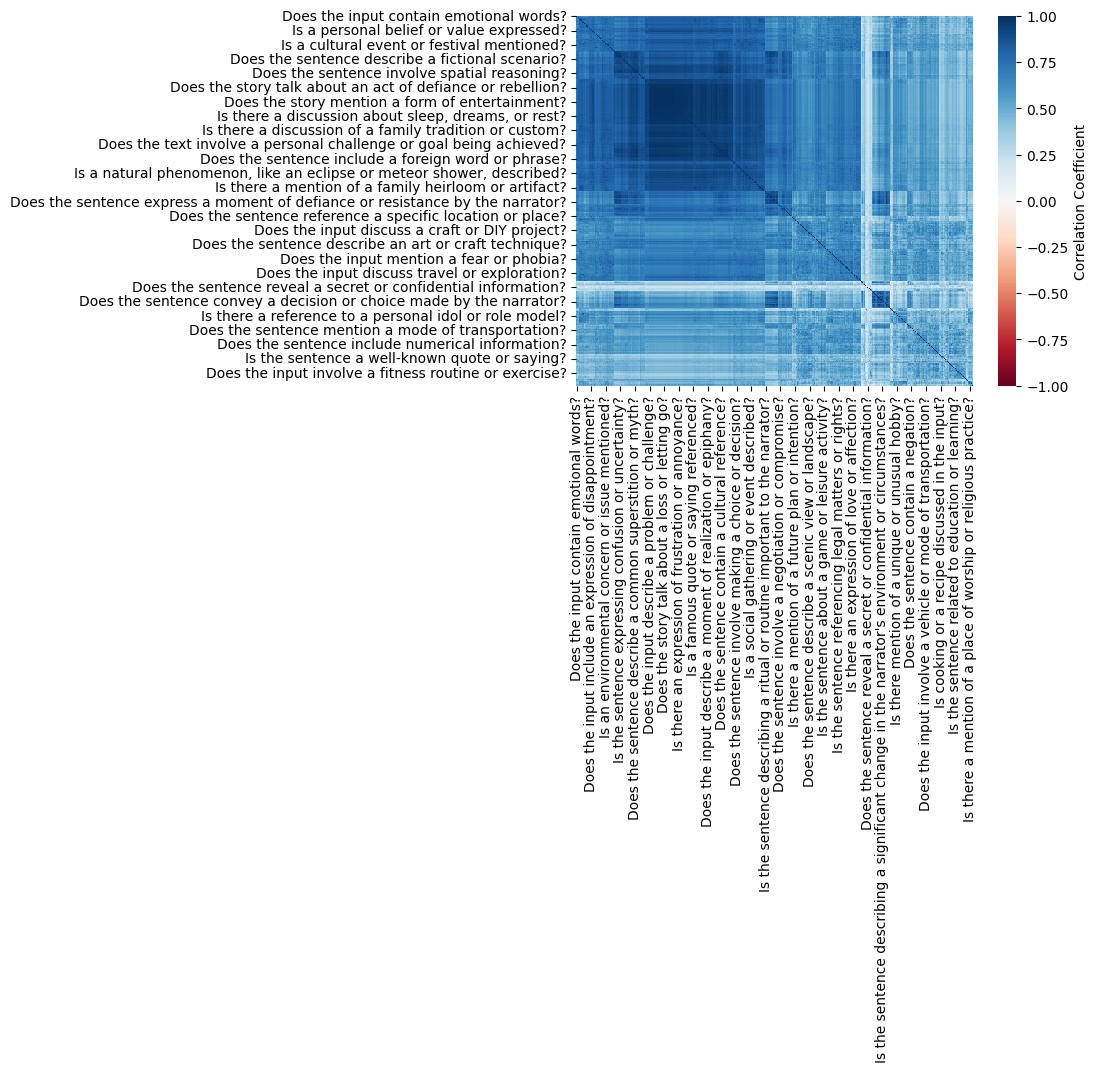

In [120]:
# cbar in bottom right
# sns.clustermap(
sns.heatmap(
    corrs,
    # cbar_pos=(0.85, 0.03, 0.03, 0.2),
    # figsize=(20, 20),
    cbar_kws={'label': 'Correlation Coefficient'},
    vmin=-1, vmax=1, cmap='RdBu')

Text(0, 0.5, 'Count')

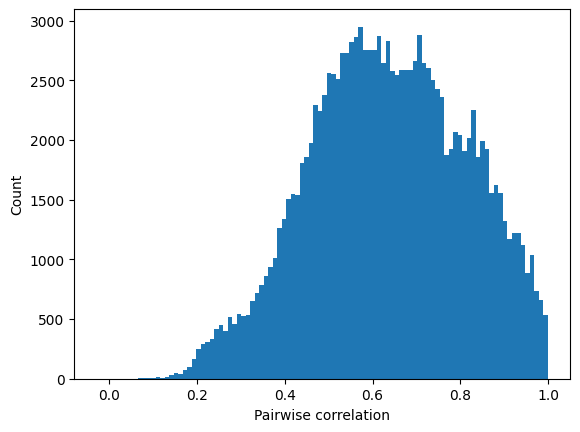

In [121]:
corrs_triu = corrs.where(np.triu(np.ones(corrs.shape), k=1).astype(bool))
plt.hist(corrs_triu.values.flatten(), bins=100)
plt.xlabel('Pairwise correlation')
plt.ylabel('Count')

In [ ]:
# exact sparsity doesnt work that well bc of lanczos sampling
# feat_mins = np.zeros(feats.shape[0])
# for i in range(feats.shape[0]):
# feat_mins[i] = (feats[i] == np.min(feats[i])).sum()